In [4]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# project specific libs
import os
import matplotlib.pyplot as plt

In [5]:
# set (local) path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/ampaim/'

In [10]:
###
# Load AB mapping file
###

# get AMPAIM+EISER mapping file w metadata; drop row 1
df_map_AB = pd.read_csv(path + 'inputs/adamcantor22_Cross_Disease_Pilot_0/Qiime2_0/qiime_mapping_file.tsv', sep='\t', header=0, index_col=0)

# get first row for any future operations
first_row = df_map_AB.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map_AB = df_map_AB.iloc[1:,]


###
# Specific replacements
###

# 526-0-twin-psaplate308 is missing a dash
df_map_AB = df_map_AB.rename(index={'526-0-twin-psaplate308': '526-0-twin-psa-plate308'})

###
# General replacements
###

# refrain from dropping NA's because you might need the columns for Q2 and you need to smoothly concat the first row

# convert index to str from float etc.
df_map_AB.index = df_map_AB.index.map(str)

# switch EISER diagnosis to eiser from NA
df_map_AB.loc[df_map_AB['Project'] == 'eiser', 'Diagnosis'] = 'eiser'

# RBB mapping file doesn't have info on duplicate controls, and the glass control info is extracted only from a subset of the names
# so we need to grab that info from AB's mapping file
samp_to_ctrlstatus = df_map_AB['Project'].to_dict()

# grab AB non-microteach samples
df_map_AB_filt = df_map_AB[df_map_AB['Project'].isin(['eiser','TWIN_PSA','glass_control','neg_control','duplicate_control'])]

df_map_AB_filt.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
#SampleID,,,,,,,,,,,,,,,,,,,,,
116783-plate305,CCTCGCATGACC,CCGGACTACHVGGGTWTCTAAT,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116783,NaN,NaN,fecal,NaN,NaN,NaN
116784-plate305,CGCGCAAGTATT,CCGGACTACHVGGGTWTCTAAT,B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116784,NaN,NaN,fecal,NaN,NaN,NaN
116785-plate305,AAGGCGCTCCTT,CCGGACTACHVGGGTWTCTAAT,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116785,NaN,NaN,fecal,NaN,NaN,NaN
116786-plate305,CGCAATGAGGGA,CCGGACTACHVGGGTWTCTAAT,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116786,NaN,NaN,fecal,NaN,NaN,NaN
116787-plate305,ACGGCGTTATGT,CCGGACTACHVGGGTWTCTAAT,E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116787,NaN,NaN,fecal,NaN,NaN,NaN


In [71]:
###
# Prepare for merge with RB mapping file
###

# load RB mapping file
df_map_RB = pd.read_csv(path + 'inputs/qiime_mapping_file_final_062123_RBB_ESR_CRPmod.csv', index_col=0)

# skip row with q2types; 140 columns
df_map_RB = df_map_RB.iloc[1:,]

# exclude unaffected since we are using TWINS_PSA from AB and controls from AB
# we only want microteach samples
df_map_RB = df_map_RB[df_map_RB['Diagnosis'].isin(['healthy','ss','sle','cd','RA','psa','pso'])]

# drop duplicate samples that appear in AB and that are controls per AB mapping file
for s in list(df_map_RB.index.values):
    if samp_to_ctrlstatus[s] in ['glass_control','duplicate_control','neg_control']:
        df_map_RB = df_map_RB.drop(s)
        
        
# merge with AB
df_meta = pd.concat([df_map_AB_filt, df_map_RB], axis=0)

# drop 'Separate' and 'Together'; presumably Q2 artifacts
df_meta = df_meta.drop(['Separate','Together'], axis=1)

# add in Project col from AB that describes controls
df_meta['Project'] = df_meta.index.map(samp_to_ctrlstatus)

###
# Specific replacements
###

# replace HxOtherDMARDs
df_meta.loc['540-0-twin-psa-plate308','HxOtherDMARDs'] = 'N'

### 
# General replacements
###

# specify float cols for later
float_cols = ['Age','BSA','CRP','DAS28','ESR','PhysicianGlobalPsA','RAPID3','SJC','TJC']

# Replace Y,N with 1,0 
df_meta = df_meta.replace({'Y':1,'N':0})

# create dict mapping diagnosis to samples
diag_to_samp = {}
for d in list(set(df_meta['Diagnosis'].values)):
    diag_to_samp[d] = list(df_meta[df_meta['Diagnosis'] == d].index.values)

### 
# Create new mapping files
### 

def export_q2(df, first_row_df):
    df_q2 = df.reset_index()
    df_q2 = pd.concat([first_row_df, df_q2])
    df_q2 = df_q2.set_index('#SampleID')
    # df_q2.loc['#q2:types',:] = 'categorical'
    df_q2 = df_q2.reset_index()
    return df_q2

# (1) filter out controls
df_meta = df_meta[df_meta['Project'].isin(['eiser','microteach','TWIN_PSA'])]

# (2) filter out treatments
# drop TWIN PSA and PSO samples that have treatment on biologics, DMARDS, MTX
drop_samples = ['275-psa-plate307', '475-psa-plate307', '542-0-twin-psa-plate308']
df_meta = df_meta.drop(drop_samples)

# remove samples that are treated other than above
df = df_meta[df_meta['Diagnosis'].isin(['pso','psa'])]

drops = []
for v in ['CurrentBiologics', 'CurrentOtherDMARDs', 'CurrentMTX', 'HxOtherDMARDs']:
    df = df_meta[df_meta[v].isin(['Y',1])]
    drops = drops + list(df.index.values)

df_meta = df_meta.drop(drops)
print('Dropped this many samples: ' + str(len(drops)))

# drop eiser samples from downstream analysis
df_meta = df_meta[df_meta['Diagnosis'] != 'eiser']

# drop unaffected twins
df_meta = df_meta[df_meta['Diagnosis'] != 'unaffected']

# export to Q2
df_meta_q2 = export_q2(df_meta, first_row_df)
# df_meta_q2.to_csv(path + 'inputs/qiime_mapping_file_noctrl_noeiser.tsv', sep='\t', index=False, na_rep='nan') 


###
# Pre-processing
###

df_meta['Diagnosis'].value_counts()

Dropped this many samples: 18


Diagnosis
RA         41
psa        27
pso        25
healthy     6
ss          5
cd          4
sle         4
Name: count, dtype: int64

In [182]:
# merge CDP and MSQ141 MMEDs qiime mapping files
# load CDP
df_cdp = pd.read_csv(path + 'inputs/qiime_mapping_file_noctrl_noeiser.tsv', sep='\t')
df_cdp['Batch'] = 'CDP'

# load MSQ141
df_141 = pd.read_csv(path + 'inputs/qiime_mapping_file_MSQ141.tsv', sep='\t')

# drop row 0 (#q2types) prior to merge
df_141 = df_141.iloc[1:,:]
df_141['Batch'] = 'MSQ141'

# merge rows
df_merge = pd.concat([df_cdp, df_141])#, axis=1)
df_merge = df_merge.set_index('#SampleID')
df_merge.loc['#q2:types',:] = 'categorical'

# note that lots of reasons might exist for batch effect, like treatment, also different diseases
# columns are not consistent (e.g. IllnessNotes in MSQ141 vs Diagnosis in CDP)
df_merge.to_csv(path + 'inputs/qiime_mapping_file_batch.tsv', sep='\t')
df_merge.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,DiseaseDurationYears,OtherSubjectID,RFpos,disease_grouping_1,disease_grouping_2,Batch,EverTreated,Medication,DiseaseActive,AgeAtVisit
#SampleID,,,,,,,,,,,,,,,,,,,,,
#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical
518-0-twin-psa-plate308,AGCCCTGCTACA,CCGGACTACHVGGGTWTCTAAT,A3,1.5,NaN,NaN,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,PsA_PsO,PsO,CDP,NaN,NaN,NaN,NaN
524-0-twin-psa-plate308,AGTAAAGATCGT,CCGGACTACHVGGGTWTCTAAT,E3,4,NaN,NaN,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,PsA_PsO,PsO,CDP,NaN,NaN,NaN,NaN
525-0-twin-psa-plate308,TTGCTGGACGCT,CCGGACTACHVGGGTWTCTAAT,F3,2,NaN,NaN,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,PsA_PsO,PsO,CDP,NaN,NaN,NaN,NaN
528-0-twin-psa-plate308,CCTAACGGTCCA,CCGGACTACHVGGGTWTCTAAT,A4,3.5,NaN,NaN,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,PsA_PsO,PsO,CDP,NaN,NaN,NaN,NaN


KruskalResult(statistic=1.3626339733210102, pvalue=0.24308151218125912)


/var/folders/48/kjsfkfqd4z1f5svhyyb5kvdw0000gn/T/ipykernel_16171/4039926270.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_alpha, x='Batch', y='shannon_entropy', palette='dark:grey', hue=None)
/Users/KevinBu/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/KevinBu/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


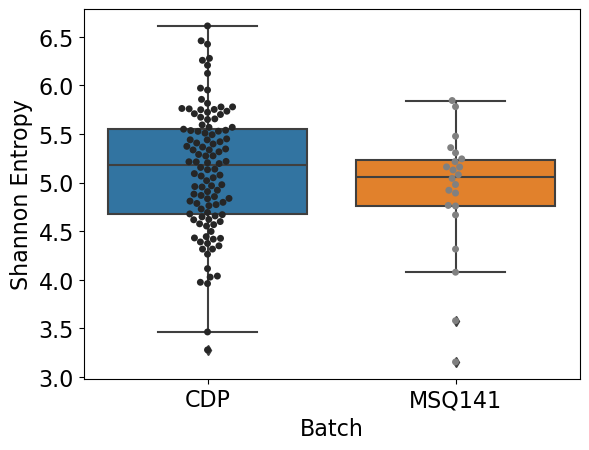

In [184]:
# plot nicer alpha div
df_alpha = pd.read_csv(path + 'inputs/Qiime2_0_KB_batch/adiv_shannon.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# drop CD
df_alpha = df_alpha[df_alpha['Diagnosis'] != 'cd']

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# KW test
print(scipy.stats.kruskal(*list(df_alpha.groupby('Batch')['shannon_entropy'].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_alpha, x='Batch', y='shannon_entropy')
sns.swarmplot(data=df_alpha, x='Batch', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Batch",fontsize=16)
ax.tick_params(labelsize=16)

plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')

KruskalResult(statistic=14.482380063114249, pvalue=0.01281888453339007)


/var/folders/48/kjsfkfqd4z1f5svhyyb5kvdw0000gn/T/ipykernel_16171/360148252.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', palette='dark:grey', hue=None)
/Users/KevinBu/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/KevinBu/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


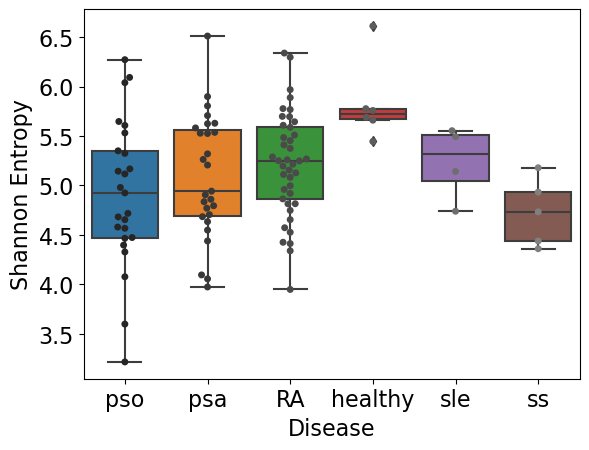

In [143]:
# plot nicer alpha div
df_alpha = pd.read_csv(path + 'inputs/Qiime2_0_KB_noctrl_noeiser/adiv_shannon.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# drop CD
df_alpha = df_alpha[df_alpha['Diagnosis'] != 'cd']

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# KW test
print(scipy.stats.kruskal(*list(df_alpha.groupby('Diagnosis')['shannon_entropy'].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_alpha, x='Diagnosis', y='shannon_entropy')
sns.swarmplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Disease",fontsize=16)
ax.tick_params(labelsize=16)

plt.savefig(path + 'inputs/Qiime2_0_KB_noctrl_noeiser/adiv.pdf')

In [139]:
# print(df_alpha.groupby('Diagnosis')['shannon_entropy'])
*list(df_alpha.groupby('Diagnosis')['shannon_entropy'].apply(list).values)


SyntaxError: can't use starred expression here (371632411.py, line 2)

In [97]:
### Loop for all LEfSe
# for LEfSe, jobs00, aggregate
# pairs, [<list of group 1> <list of group 2>]
### Loop for all LEfSe
# for LEfSe, jobs00, aggregate
# pairs, [<list of group 1> <list of group 2> <aggregate group 2>]
comp_to_groups = {
    'AvH': (['healthy'],['psa','pso','ss','cd','sle','RA'],['affected']), # healthy vs disease aggregate, jobs03
    'RAvH': (['healthy'],['RA'],['RA']), # jobs04 
    'PsOvH': (['healthy'],['pso','pso'],['PsA']), #jobs05
    'PsAvH': (['healthy'],['psa','psa'],['PsA']), #jobs05
    'SSvH': (['healthy'],['ss'],['ss']), #jobs06
    'SLEvH': (['healthy'],['sle'],['sle']),
    'CDvH': (['healthy'],['cd'],['cd']), 
}

for c in comp_to_groups:
    # unpack tuples
    healthy, disease, aggregate = comp_to_groups[c]
    
    # subset relevant diseases
    df_meta_XvH = df_meta[df_meta['Diagnosis'].isin(healthy + disease)]
    
    # change all diseases to aggregate string
    df_meta_XvH.loc[df_meta_XvH['Diagnosis'].isin(disease), 'Diagnosis'] = aggregate[0]

    # add first row
    df_meta_XvH = df_meta_XvH.reset_index()
    df_meta_XvH = pd.concat([first_row_df, df_meta_XvH])
    df_meta_XvH = df_meta_XvH.set_index('#SampleID')

    # export to csv
    # df_meta_XvH.to_csv(path + 'inputs/qiime_mapping_file_noctrl_' + c + '.tsv', sep='\t', na_rep='nan')
    df_meta_XvH.head()

df_meta_XvH.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected,CCPpos,Disease,DiseaseDurationYears,OtherSubjectID,RFpos
#SampleID,,,,,,,,,,,,,,,,,,,,,
#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,NaN,NaN,NaN,NaN,NaN
U739-nyuibd-plate307,GCAAAGGCCCGC,CCGGACTACHVGGGTWTCTAAT,E12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,fecal,NaN,NaN,NaN,NaN,disease,NaN,U739,NaN
U747-nyuibd-plate307,CTCCCACTAGAG,CCGGACTACHVGGGTWTCTAAT,F12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,M,fecal,NaN,NaN,NaN,NaN,disease,NaN,U747,NaN
U777-nyuibd-plate307,AATAGATGCTGA,CCGGACTACHVGGGTWTCTAAT,G12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,M,fecal,NaN,NaN,NaN,NaN,disease,NaN,U777,NaN
U885-nyuibd-plate307,AACGCTTCTTAT,CCGGACTACHVGGGTWTCTAAT,H12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,fecal,NaN,NaN,NaN,NaN,disease,NaN,U885,NaN


In [ ]:
# First go to R and run the DMM script to generate the cluster assignments and scores
#df_dmm = pd.read_csv(path + 'outputs/visualizations_dir_nyu/dmm_lplc_relabd_assign.tsv', sep='\t', index_col=0)
df_dmm = pd.read_csv(path + 'outputs/visualizations_dir_psara/dmm_lplc_relabd_assign.tsv', sep='\t', index_col=0)
df_final = pd.concat([df_nyu2, df_dmm], axis=1)
df_final.index.name = '#SampleID'

# export for rerun Q2
df_disease = export_q2(df_final, first_row_df)
df_disease.to_csv(path + 'inputs/qiime_mapping_file_psara_dmm.tsv', sep='\t', index=False, na_rep='nan')

# assess chi square GOF
df_final = df_final.dropna(axis='rows', subset=['Diagnosis'])

# new col for SJ TJC binary
df_final['TJCpos'] = df_final['TJC'].map(lambda x: 1 if float(x) > 0 else 0)
df_final['SJCpos'] = df_final['SJC'].map(lambda x: 1 if float(x) > 0 else 0)

# DMM GROUPING
dmm = df_final['dmm.grp'].values
diag = df_final['Diagnosis'].values

for col in ['Diagnosis','disease_grouping_1','disease_grouping_2']:
    diag = df_final[col].values
    for d in list(set(diag)):
        y = np.array([0 if x == d else 1 for x in diag])
        x,p = scipy.stats.chisquare(f_obs=[dmm, y], axis=None)#, f_exp=None, ddof=0, axis=0)
        #if p<0.05:
        print(col)
        print(d)
        print(p)
print('Done')


In [ ]:
# association of DMM clusters with metadata variables
# df_final has the metadata
df_meta_sub = df_final.copy()

# drop na before doing association testing
# print len of resulting df
# Chisq: 
cs = ['ESRpos','CRPpos','CCPpos','RFpos','Enthesitis','Dactylitis','Sex_bin','Hispanic', 'SJCpos', 'TJCpos'] # race requires a multi-class chi-sq

# cast to float
df_meta_sub['ESR'] = np.array([float(x) for x in list(df_meta_sub['ESR'].values)])
df_meta_sub['CRP'] = np.array([float(x) for x in list(df_meta_sub['CRP'].values)])

# new columns based on threshold definitions
df_meta_sub['ESRpos'] = np.where(df_meta_sub['ESR'] > 20, 1, 0)
df_meta_sub['CRPpos'] = np.where(df_meta_sub['CRP'] > 5, 1, 0)
df_meta_sub['Sex_bin'] = np.where(df_meta_sub['Sex'] == 'F', 1, 0)

for c in cs:
    print(c)
    df_meta_sub[c] = np.array([float(x) for x in list(df_meta_sub[c].values)])
    df_sub = df_meta_sub[['dmm.grp',c]]
    df_sub = df_sub.dropna(axis='rows') #subset=[]
    
    dmm = df_sub['dmm.grp'].values
    y = df_sub[c].values
    x,p = scipy.stats.chisquare(f_obs=[dmm, y], axis=None)
    print(x)
    
#    if p < 0.05:
    print(p)

# T-test
tt = ['ESR', 'CRP', 'SJC', 'TJC', 'BSA', 'DiseaseDuration', 'Age', 'DAS28', 'RAPID3']

# cast to float


for t in tt:
    print(t)
    df_meta_sub[t] = np.array([float(x) for x in list(df_meta_sub[t].values)])
    df_sub = df_meta_sub[['dmm.grp',t]]
    df_sub = df_sub.dropna(axis='rows') #subset=[]
    
    a = df_sub[df_sub['dmm.grp'] == 1][t].values
    b = df_sub[df_sub['dmm.grp'] == 2][t].values
    t,p = scipy.stats.ttest_ind(a,b)
    print(t)
    
    if p < 0.05:
        print(p)

    
print('Done')

In [ ]:
# SJC?
df_sub = df_meta_sub[['dmm.grp', 'SJC']]
df_sub = df_sub.dropna()
a = df_sub[df_sub['dmm.grp'] == 1]['SJC'].values
b = df_sub[df_sub['dmm.grp'] == 2]['SJC'].values
t, p = scipy.stats.ttest_ind(a, b)
print(t, p)

sns.boxplot([a, b])


In [ ]:
# correlation of beta div with SJC and CRP
df_pcoa = pd.read_csv(path + 'inputs/Qiime2_psara_dmm/core_metrics_results/ordination.txt', 
                      sep='\t', 
                      header=None,
                      index_col=0,
                      skiprows=9)#error_bad_lines=False)#on_bad_lines='skip')
df_pcoa = df_pcoa.drop(['Biplot','Site constraints'])
df_pcoa.columns = df_pcoa.columns.map(lambda x: 'X' + str(x))

df_test = pd.concat([df_final, df_pcoa], axis=1)
df_test.head()

pcs = ['X1', 'X2', 'X3']
var = ['SJC', 'CRP', 'CRP_drop']
for x in pcs:
    for y in var:
        print(x)
        print(y)
        
        if y == 'CRP_drop':
            y = 'CRP'
            df_corr = df_test[[x,y]]
            df_corr = df_corr.dropna()
            df_corr = df_corr.astype(float)
            df_corr[y] = df_corr[y].map(lambda x: 0 if x > 175 else x)
            r, p = scipy.stats.pearsonr(x=df_corr[x],y=df_corr[y])
            sns.lmplot(data=df_corr, x=x, y=y)
            print(r, p)
            plt.savefig(path + 'inputs/Qiime2_psara_dmm/' + x + '_' + 'CRP_drop' + '.pdf')
            r, p = scipy.stats.spearmanr(a=df_corr[x],b=df_corr[y])
            print(r,p)

        else:
            df_corr = df_test[[x,y]]
            df_corr = df_corr.dropna()
            df_corr = df_corr.astype(float)

            r, p = scipy.stats.pearsonr(x=df_corr[x],y=df_corr[y])
            sns.lmplot(data=df_corr, x=x, y=y)
            print(r, p)
            plt.savefig(path + 'inputs/Qiime2_psara_dmm/' + x + '_' + y + '.pdf')
            r, p = scipy.stats.spearmanr(a=df_corr[x],b=df_corr[y])
            print(r,p)


In [ ]:
pcopri = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__copri'

# compare distances
RA_pc = df_otu[df_otu['Diagnosis'] == 'RA'][pcopri].values
H_pc = df_otu[df_otu['Diagnosis'] == 'healthy'][pcopri].values

t, p = scipy.stats.ttest_ind(RA_pc, H_pc)
print(t, p)

sns.boxplot([RA_pc, H_pc])


In [ ]:
# PICRUST2
# don't forget to uncompress path_abun_unstrat.tsv.gz
# 393 columns/pathways represented here
df_fxn = pd.read_csv(path + 'inputs/adamcantor22_Cross_Disease_Pilot_0/PiCRUSt2_0/picrust2_out/pathways_out/path_abun_unstrat.tsv', sep='\t', index_col=0).T
KO_names = list(df_fxn.columns.values)

# normalize by row total (per sample basis)
df_fxn = df_fxn.div(df_fxn.sum(axis=1), axis=0)
df_fxn.to_csv(path + 'inputs/df_pathways.tsv', sep='\t')

# new metadata for concatenation
# df_meta_sample = df_meta.set_index('SampleID')

# concatenate
# df_pi = pd.concat([df_meta_sample, df_fxn], axis=1)
# df_pi.head()

#gene names; KO is just a placeholder
# KO_names = [x for x in df_pi.columns.values if x[0] == 'K']
# KO_names = [x for x in df_pi.columns.values if x[-3:] == 'PWY']

# RA first
# df_KO = df_pi[df_pi['Diagnosis'].isin(['healthy','RA'])]#'pso','psa'])]
# df_KO = df_KO[KO_names + ['Diagnosis']]

# subset
# df_ra_KO = df_KO[df_KO['Diagnosis'].isin(['RA'])]#'pso','psa'])]
# df_healthy_KO = df_KO[df_KO['Diagnosis'].isin(['healthy'])]


df_fxn.head()

In [ ]:
# get filtered meta for float cols only
df_meta_filt = df_meta[float_cols]

# merge OTU and df_meta
df_complete = pd.concat([df_otu, df_meta_filt, df_fxn], axis=1)
df_complete.head()

In [ ]:
# aggregate disease vs healthy analysis first
diag_healthy = ['healthy'] #['unaffected','healthy']
diag_disease = ['RA', 'psa', 'pso', 'ss', 'cd', 'sle']

# 
samp_healthy, samp_disease = [], []
for d in diag_healthy:
    samp_healthy = samp_healthy + diag_to_samp[d]
for d in diag_disease:
    samp_disease = samp_disease + diag_to_samp[d]
    
df_complete_healthy = df_complete.loc[samp_healthy]
df_complete_disease = df_complete.loc[samp_disease]

# save with index_label to avoid CUTIE errors
df_complete_healthy.to_csv(path + 'inputs/df_complete_healthy.tsv', sep='\t', index_label='Samples')
df_complete_disease.to_csv(path + 'inputs/df_complete_disease.tsv', sep='\t', index_label='Samples')

df_complete_healthy


#df_meta['Diagnosis'].value_counts()
#df_disease = df_complete[df_complete['Diagnosis']]
# samp_disease


In [ ]:
# plotting differential picrust metacyc pathways
pvals = []
tvals = []
KO = KO_names#[0:1000]

# get OG p values
for k in KO:
    x = df_complete_healthy[k].values
    y = df_complete_disease[k].values
    t, p = scipy.stats.ttest_ind(x,y)
    # remove nans or else, but this might not be the best way
    # https://github.com/statsmodels/statsmodels/issues/2899
    if np.isnan(p):
        pvals.append(1)
    else:
        pvals.append(p)
        tvals.append(t)


# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.fdrcorrection.html
qvals = statsmodels.stats.multitest.fdrcorrection(np.array(pvals), alpha=0.05, method='indep', is_sorted=False)[1]        
# one day the scipy library will have it (1.11, the next release apparently as of 8/29/2023)
# scipy.stats.false_discovery_control(ps)

df_complete_nonfilt = pd.concat([df_otu, df_meta, df_fxn], axis=1)

try:
    os.mkdir(path + 'outputs/metacycp/')
except:
    pass

try:
    os.mkdir(path + 'outputs/metacycq/')
except:
    pass


# convert to q values
sig_list = []
for i in range(len(KO)):
    p, q = pvals[i], qvals[i]
    k = KO[i]      
    if p < 0.05:        
        sig_list.append(k)
        print(k)
        print(tvals[i], pvals[i])
        sns.set(style="darkgrid")
        plt.subplots(figsize=(6, 4))
        plt.tight_layout()
        ax = sns.boxplot(data=df_complete_nonfilt, x='Diagnosis', y=k)

        # save the plot as PNG file
        plt.savefig(path + 'outputs/metacycp/' + k + '.png',  bbox_inches="tight")
        if q < 0.05:
            plt.savefig(path + 'outputs/metacycq/' + k + '.png',  bbox_inches="tight")
            
        plt.close()
                        
            
print(len(sig_list))



In [ ]:
# combine LEfSe results
# all files are lefse_table.tsv
'''
outputs/
	jobs02							# LEfSe for PsAvH
	jobs03							# LEfSe for PsOvH
graphs/
    LEfSe_3                         # AvH
    LEfSe_4                         # RAvH
    LEfSe_5                         # PsA+PsO aka PSvH
    LEfSe_6                         # SSvH
    LEfSe_7                         # SLEvH
    LEfSe_8                         # CDvH
    LEfSe_9                         # SS+SLE aka SSSLEvH
    LEfSe_10                        # RA+PsA aka RAPsAvH
'''
# create dict mapping diagnosis to lefse results
# start w/ two disease for play testing
# eventually can consider the enriched in H set, but start with enriched in diseased set
diag_to_lefse_disease = {
    'PsA': [],
    'PsO': [],
    'PS': [],
    'A': [],
    'RA': [],
    'SS': [],
    'SLE': [],
    'SSSLE': [],
    'CD': [],
    'RAPsA': []
}

diag_to_path ={
    'PsA': 'outputs/jobs02/',
    'PsO': 'outputs/jobs03/',
    'PS': 'graphs/LEfSe_5/',
    'A': 'graphs/LEfSe_3/',
    'RA': 'graphs/LEfSe_4/',
    'SS': 'graphs/LEfSe_6/',
    'SLE': 'graphs/LEfSe_7/',
    'CD': 'graphs/LEfSe_8/',
    'SSSLE': 'graphs/LEfSe_9/',
    'RAPsA': 'graphs/LEfSe_10/',
}

for diag in diag_to_path:
    # import df, rename columns
    df_lefse = pd.read_csv(path + diag_to_path[diag] + 'lefse_results.res', sep='\t', header=None)    
    df_lefse.columns = ['Taxa','Effect_Size', 'Enriched_Group', 'Test_statistic','P_value']
    
    # replace dash with nan, cast to float
    df_lefse = df_lefse.replace('-', np.nan)
    df_lefse['P_value'] = df_lefse['P_value'].astype(float) 
    
    # get sig results and results pertaining to enriched group
    df_lefse = df_lefse[df_lefse['P_value'] <= 0.05]
    df_lefse = df_lefse[df_lefse['Enriched_Group'] != 'healthy']
    
    # drop na
    df_lefse = df_lefse.dropna()
    
    print(diag)
    print(len(df_lefse))
    #df_lefse = df_lefse.sort_values('Effect_Size')
    df_lefse.to_csv(path + 'outputs/jobs04/' + diag + '_lefse_sig.tsv', sep='\t')
    diag_to_lefse_disease[diag] = list(df_lefse['Taxa'].values)

# convert to df for output file to R
# summary_df = pd.Dataframe()
# summary_df = pd.DataFrame.from_dict(diag_to_lefse)
# summary_df




In [ ]:
# input query as list of sets
query = []
# query = ['SLE','SSSLE','RA','RAPsA','SS','PsO','PsA','PS','A']
query = ['PS','A']
query = ['RA','RAPsA']

# compute intersection 
result = set.intersection(*[set(diag_to_lefse_disease[q]) for q in query])
print(len(result))
print(result)


In [ ]:
# combine LEfSe results
# all files are lefse_table.tsv
'''
outputs/
	jobs02							# LEfSe for PsAvH
	jobs03							# LEfSe for PsOvH
graphs/
    LEfSe_3                         # AvH
    LEfSe_4                         # RAvH
    LEfSe_5                         # PsA+PsO aka PSvH
    LEfSe_6                         # SSvH
    LEfSe_7                         # SLEvH
    LEfSe_8                         # CDvH
    LEfSe_9                         # SS+SLE aka SSSLEvH
    LEfSe_10                        # RA+PsA aka RAPsAvH
'''
# create dict mapping diagnosis to lefse results
# start w/ two disease for play testing
# eventually can consider the enriched in H set, but start with enriched in diseased set
diag_to_lefse_healthy = {
    'PsA': [],
    'PsO': [],
    'PS': [],
    'A': [],
    'RA': [],
    'SS': [],
    'SLE': [],
    'SSSLE': [],
    'CD': [],
    'RAPsA': []
}

diag_to_path ={
    'PsA': 'outputs/jobs02/',
    'PsO': 'outputs/jobs03/',
    'PS': 'graphs/LEfSe_5/',
    'A': 'graphs/LEfSe_3/',
    'RA': 'graphs/LEfSe_4/',
    'SS': 'graphs/LEfSe_6/',
    'SLE': 'graphs/LEfSe_7/',
    'CD': 'graphs/LEfSe_8/',
    'SSSLE': 'graphs/LEfSe_9/',
    'RAPsA': 'graphs/LEfSe_10/',
}

for diag in diag_to_path:
    # import df, rename columns
    df_lefse = pd.read_csv(path + diag_to_path[diag] + 'lefse_results.res', sep='\t', header=None)    
    df_lefse.columns = ['Taxa','Effect_Size', 'Enriched_Group', 'Test_statistic','P_value']
    
    # replace dash with nan, cast to float
    df_lefse = df_lefse.replace('-', np.nan)
    df_lefse['P_value'] = df_lefse['P_value'].astype(float) 
    
    # get sig results and results pertaining to enriched group
    df_lefse = df_lefse[df_lefse['P_value'] <= 0.05]
    df_lefse = df_lefse[df_lefse['Enriched_Group'] == 'healthy']
    
    # drop na
    df_lefse = df_lefse.dropna()
    
    print(diag)
    print(len(df_lefse))
    #df_lefse = df_lefse.sort_values('Effect_Size')
    df_lefse.to_csv(path + 'outputs/jobs04/' + diag + '_lefse_healthy_sig.tsv', sep='\t')
    diag_to_lefse_healthy[diag] = list(df_lefse['Taxa'].values)

# convert to df for output file to R
# summary_df = pd.Dataframe()
# summary_df = pd.DataFrame.from_dict(diag_to_lefse)
# summary_df




In [ ]:
# input query as list of sets
query = []
query = ['SLE','SSSLE','RA','RAPsA','SS','PsO','PsA','PS','A']
query = ['SLE','RA','SS','PsO','PsA']

# compute intersection 
result = set.intersection(*[set(diag_to_lefse_healthy[q]) for q in query])
print(len(result))
print(result)
